In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import botorch

sns.set(style='whitegrid', font_scale=1.75)

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# %pdb

In [3]:
import torchsort

import sys
sys.path.append('..')
from experiments.std_bayesopt.helpers import *

In [4]:
# def generate_target_grid(bounds, resolution):
#     target_dim = bounds.shape[1]
#     grid_coords = [np.linspace(bounds[0,i], bounds[1,i], resolution) for i in range(target_dim)]
#     target_grid = np.stack(np.meshgrid(*grid_coords), axis=-1)
#     target_grid = torch.tensor(target_grid).view(-1, target_dim)
#     # target_grid = target_grid.to(val_inputs)
#     return target_grid.float()

# class ConformalPosterior(botorch.posteriors.Posterior):
#     def __init__(self, X, gp, target_bounds, alpha):
#         # self.conf_pred_mask = conformal_gp_regression(gp, X, target_grid, alpha)
#         self.gp = gp
#         self.X = X
#         self.target_bounds = target_bounds
#         self.alpha = alpha
        
#     @property
#     def device(self):
#         return self.X.shape
    
#     @property
#     def dtype(self):
#         return self.X.shape
    
#     @property
#     def event_shape(self):
#         return self.X.shape[:-2]
    
#     def rsample(self, sample_shape=()):
#         target_grid = generate_target_grid(self.target_bounds, *sample_shape)
#         target_grid = target_grid.to(self.X)
#         # for later on in the evaluation
#         self.gp.conf_pred_mask = conformal_gp_regression(self.gp, self.X, target_grid, self.alpha)
#         return target_grid.expand(*self.X.shape[:-1], -1, -1).unsqueeze(0)
    
# class PassSampler(botorch.sampling.MCSampler):
#     def __init__(self, num_samples):
#         super().__init__(batch_range=(0, -2))
#         self._sample_shape = torch.Size([num_samples])
#         self.collapse_batch_dims = True
        
#     def forward(self, posterior):
#         return posterior.rsample(self.sample_shape).transpose(-2, -3)
    
#     def _construct_base_samples(self, posterior, shape):
#         pass
    
# class ConformalSingleTaskGP(botorch.models.SingleTaskGP):
#     is_conformal = False
    
#     def conformal(self):
#         self.is_conformal = True
    
#     def standard(self):
#         self.is_conformal = False
        
#     def posterior(self, X, observation_noise=False, posterior_transform=None):
#         if self.is_conformal:
#             # TODO: expose these
#             return ConformalPosterior(X, self, torch.tensor([[-2., 2.]]).t(), alpha=0.05)
#         else:
#             return super().posterior(
#                 X = X, observation_noise=observation_noise, posterior_transform=posterior_transform
#             )
    
#     @property
#     def batch_shape(self):
#         if self.is_conformal:
#             try:
#                 return self.conf_pred_mask.shape
#             except:
#                 pass
#         return self.train_inputs[0].shape[:-2]
        

In [5]:
# from gpytorch.lazy import DiagLazyTensor
# import torch.nn.functional as F

# def conformal_gp_regression(gp, test_inputs, target_grid, alpha, **kwargs):
#     """
#     Full conformal Bayes for exact GP regression.
#     Args:
#         gp (gpytorch.models.GP)
#         inputs (torch.Tensor): (batch, q, input_dim)
#         target_grid (torch.Tensor): (grid_size, target_dim)
#         alpha (float)
#     Returns:
#         conf_pred_mask (torch.Tensor): (batch, grid_size)
#     """
#     # retraining: condition the GP at every target grid point for every test input
#     expanded_inputs = test_inputs.unsqueeze(-3).expand(
#         *[-1]*(test_inputs.ndim-2), target_grid.shape[0], -1, -1
#     )
#     expanded_targets = target_grid.expand(*test_inputs.shape[:-1], -1, -1)
#     # the q batch and grid size are flipped
#     expanded_targets = expanded_targets.transpose(-2, -3)
    
#     # cleanup
#     gp.train()
#     gp.eval() # clear caches
#     gp.standard()
#     gp.posterior(expanded_inputs)
#     gp.conf_pred_mask = None
#     gp.conformal()
    
#     updated_gps = gp.condition_on_observations(expanded_inputs, expanded_targets)
    
#     # get ready to compute the conformal scores
#     train_inputs = updated_gps.train_inputs[0]
#     train_labels = updated_gps.prediction_strategy.train_labels
# #     print("updaed gp:", updated_gps.prediction_strategy.train_labels.shape, train_inputs.shape)
#     train_labels = train_labels.unsqueeze(-1)  # (num_test, grid_size, num_train + 1, target_dim)
#     lik_train_train_covar = updated_gps.prediction_strategy.lik_train_train_covar
#     prior_mean = updated_gps.prediction_strategy.train_prior_dist.mean.unsqueeze(-1)
#     prior_covar = updated_gps.prediction_strategy.train_prior_dist.lazy_covariance_matrix
#     noise = updated_gps.likelihood.noise
    
#     # compute conformal scores (posterior predictive log-likelihood)
#     eig_vals, eig_vecs = prior_covar.symeig(eigenvectors=True)  # Q \Lambda Q^{-1} = K_{XX}
#     diag_term = DiagLazyTensor(eig_vals / (eig_vals + noise))  # \Lambda (\Lambda + \sigma I)^{-1}
#     lhs = eig_vecs @ diag_term
#     mean_rhs = eig_vecs.transpose(-1, -2) @ (train_labels - prior_mean)
#     pred_mean = (prior_mean + lhs @ mean_rhs).squeeze(-1)
#     covar_rhs = DiagLazyTensor(eig_vals) @ eig_vecs.transpose(-1, -2)
#     pred_covar = prior_covar - (lhs @ covar_rhs)
#     pred_var = (pred_covar.diag() + noise).clamp(min=1e-6)
#     pred_dist = torch.distributions.Normal(pred_mean, pred_var.sqrt())
#     conf_scores = pred_dist.log_prob(train_labels.squeeze(-1))
    
#     ranks_by_score = torch.stack([
#         torchsort.soft_rank(
#             cc, regularization="l2", regularization_strength=0.1
#         ) for cc in conf_scores
#     ]) # seems to be returning one indexed values for some reason
#     num_total, _ = ranks_by_score.max(-1, keepdim=True)
#     norm_ranks = (ranks_by_score) / num_total
#     conf_pred_mask = F.threshold(norm_ranks[..., -1], alpha, 0.) / norm_ranks[..., -1]
#     return conf_pred_mask

In [6]:
# from botorch.acquisition import qExpectedImprovement, qNoisyExpectedImprovement

# class qConformalExpectedImprovement(qExpectedImprovement):
#     def forward(self, X):
#         unconformalized_acqf = super().forward(X) # batch x grid x q
#         return (self.model.conf_pred_mask * unconformalized_acqf).sum(-1)
    
# class qConformalNoisyExpectedImprovement(qNoisyExpectedImprovement):
#     def forward(self, X):
#         unconformalized_acqf = super().forward(X) # batch x grid x q
#         return (self.model.conf_pred_mask * unconformalized_acqf).sum(-1)        

In [7]:
obj_fn = lambda x: np.maximum(-0.125 * x ** 2 + 16 * np.sin(x), 0)

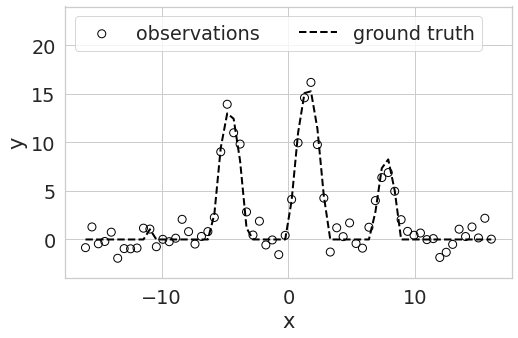

In [8]:
fig = plt.figure(figsize=(8, 5))

noise_scale = 1.
x_bounds = torch.tensor((-16., 16.)).view(-1, 1)

x = np.linspace(*x_bounds, 64)
f = obj_fn(x)
y = f + noise_scale * np.random.randn(*f.shape)

plt.scatter(x, y, edgecolors='black', facecolors='none', label='observations', s=64, zorder=3)
plt.plot(x, f, color='black', linestyle='--', label='ground truth', linewidth=2, zorder=2)

plt.ylabel('y')
plt.xlabel('x')
plt.ylim((-4, 24))
plt.legend(loc='upper left', ncol=2)

In [9]:
import botorch
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import IIDNormalSampler

from gpytorch.mlls import ExactMarginalLogLikelihood

In [10]:
# import sys
# sys.path.append("..")

In [11]:
from lambo.utils import DataSplit, update_splits
from lambo.optimizers.pymoo import Normalizer

cutoff = np.max(np.where(x < -8))
x_min, y_min = x.min(0), y.min(0)
x_range, y_range = x.max(0) - x_min, y.max(0) - y_min

x_norm = Normalizer(
    loc=x_min + 0.5 * x_range,
    scale=x_range / 2.,
)
y_norm = Normalizer(
    loc=y_min + 0.5 * y_range,
    scale=y_range / 2.,
)

train_x = x[:cutoff]
train_y = y[:cutoff]

all_inputs = torch.tensor(x_norm(x), device=DEVICE).view(-1, 1)
all_targets = torch.tensor(y_norm(y), device=DEVICE).view(-1, 1)
target_dim = all_targets.shape[-1]

new_split = DataSplit(
    all_inputs[:cutoff].cpu().numpy(), all_targets[:cutoff].cpu().numpy()
)
train_split, val_split, test_split = update_splits(
    train_split=DataSplit(),
    val_split=DataSplit(),
    test_split=DataSplit(),
    new_split=new_split,
    holdout_ratio=0.2
)

input_bounds = torch.tensor([-1., 1.], device=DEVICE).view(-1, 1)

In [12]:
def run_datashift_opt(splits, acqf="ei"):
    def draw_plot(ax):
        # plot p(f | x, D)
        ax.plot(all_inputs.cpu(), f_hat_mean, color='blue', linewidth=2, zorder=4, label='p(f | x, D)')
        ax.fill_between(all_inputs.view(-1).cpu(), f_hat_mean - 1.96 * f_hat_std, f_hat_mean + 1.96 * f_hat_std,
                        color='blue', alpha=0.25)

        # plot a(x)
        ax.plot(all_inputs.cpu(), acq_vals, color='green', zorder=5, linewidth=2, label='a(x)')
        ax.scatter(input_query.cpu(), target_query.cpu(), marker='x', color='red', label='x*', zorder=5,
                   s=32, linewidth=2)

        # plot observed
        ax.scatter(train_inputs.cpu(), train_targets.cpu(), edgecolors='black', facecolors='black',
                   label='D', s=32, zorder=3)

        # plot true function
        ax.plot(all_inputs.cpu(), y_norm(f), color='black', linestyle='--', label='f')

        ax.set_ylim((-2., 2.))

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        return ax

    train_split, val_split, test_split = splits
    
    if acqf == 'ei':
        acqf_init = lambda gp, best_f: qExpectedImprovement(
            gp,
            best_f=train_targets.max(0)[0],
            sampler=IIDNormalSampler(64)
        )
    elif acqf == "nei":
        acqf_init = lambda gp, best_f: qNoisyExpectedImprovement(gp, X_baseline=train_inputs, sampler=IIDNormalSampler(64))
    elif acqf == 'conformal_ei':
        def acqf_init(gp, best_f):
            gp.conformal()
            return qConformalExpectedImprovement(
                gp,
                best_f=train_targets.max(0)[0],
                sampler=PassSampler(32),
                cache_root=False
            )
    elif acqf == "conformal_nei":
        def acqf_init(gp, best_f):
            gp.conformal()
            return qConformalNoisyExpectedImprovement(
                gp,
                X_baseline=train_inputs,
                sampler=PassSampler(32),
                cache_root=False
            )
        
    num_rounds = 32
    plot_interval = 8
    
    queried_targets = []
    for round_idx in range(num_rounds):
        train_inputs = torch.tensor(train_split[0], device=DEVICE)
        train_targets = torch.tensor(train_split[1], device=DEVICE)

        matern_gp = ConformalSingleTaskGP(
            train_X=train_inputs,
            train_Y=train_targets,
            alpha=0.05,
            conformal_bounds=torch.tensor([[-2., 2.]]).t(),
        ).to(DEVICE)
        mll = ExactMarginalLogLikelihood(matern_gp.likelihood, matern_gp)
        fit_gpytorch_model(mll)
        # acq_fn = UpperConfidenceBound(matern_gp, beta=8.)
        # HERE WE USE EI
        # acq_fn = ExpectedImprovement(matern_gp, best_f=train_targets.max())
        acq_fn = acqf_init(matern_gp, train_targets.max())

        matern_gp.requires_grad_(False)
        matern_gp.eval()
        with torch.no_grad():
            f_hat_dist = matern_gp(all_inputs)
            y_hat_dist = matern_gp.likelihood(f_hat_dist)
            f_hat_mean = f_hat_dist.mean.cpu()
            f_hat_std = f_hat_dist.variance.sqrt().cpu()
            y_hat_mean = f_hat_mean.cpu()
            y_hat_std = y_hat_dist.variance.sqrt().cpu()
            acq_vals = acq_fn(all_inputs[:, None]).cpu()

        input_query = optimize_acqf(acq_fn, input_bounds, 1, num_restarts=4, raw_samples=16)[0]
        x_query = x_norm.inv_transform(input_query.cpu().numpy())
        f_query = obj_fn(x_query)
        y_query = f_query + noise_scale * np.random.randn(*f_query.shape)
        target_query = torch.tensor(y_norm(y_query), device=DEVICE)

        if round_idx % plot_interval == 0:
            print(f'{train_split[0].shape[0]} train, {val_split[0].shape[0]} val, {test_split[0].shape[0]} test')
            fig = plt.figure(figsize=(8, 5))
            ax = fig.add_subplot(1, 1, 1)
            draw_plot(ax)

        new_split = DataSplit(
            input_query.reshape(-1, 1).cpu(),
            target_query.reshape(-1, 1).cpu(),
        )
        train_split, val_split, test_split = update_splits(
            train_split, val_split, test_split, new_split, holdout_ratio=0.2
        )
        queried_targets.append(target_query)
    plt.show()
    return torch.tensor(queried_targets)

/home/sam/miniconda3/envs/conf-bo-env/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


11 train, 1 val, 3 test
17 train, 2 val, 4 test
22 train, 5 val, 4 test
28 train, 6 val, 5 test


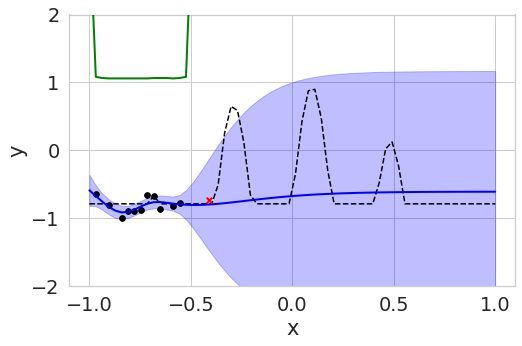

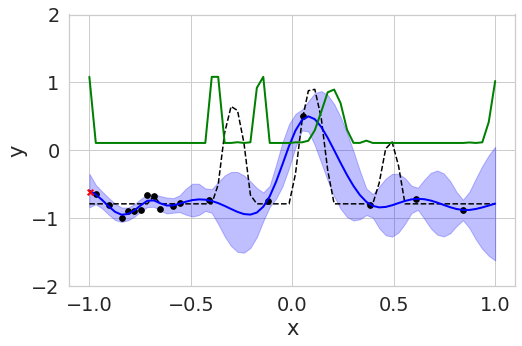

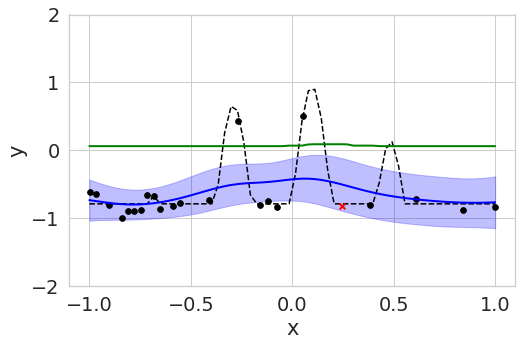

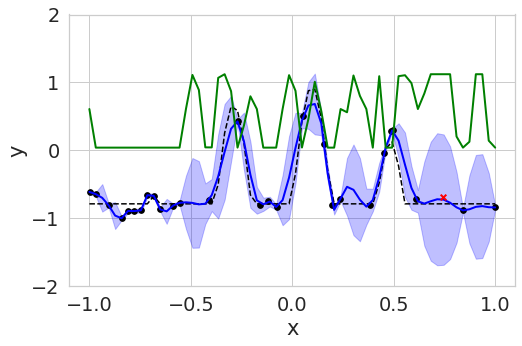

11 train, 1 val, 3 test
17 train, 3 val, 3 test
24 train, 4 val, 3 test
29 train, 5 val, 5 test


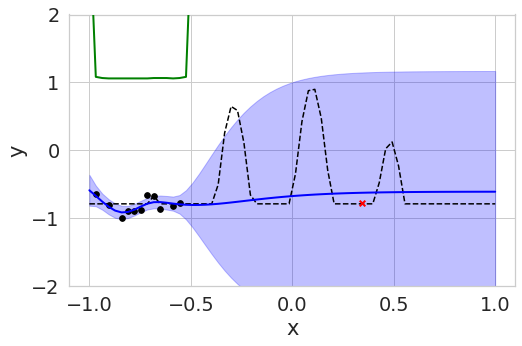

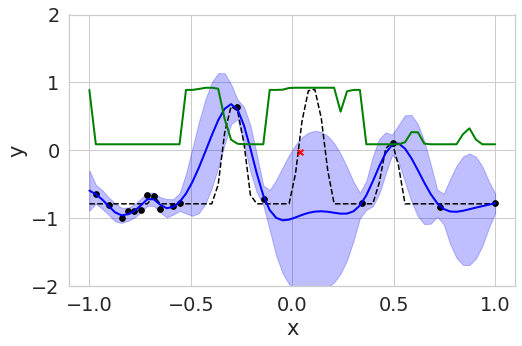

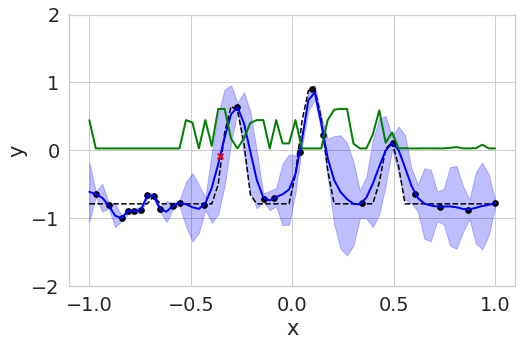

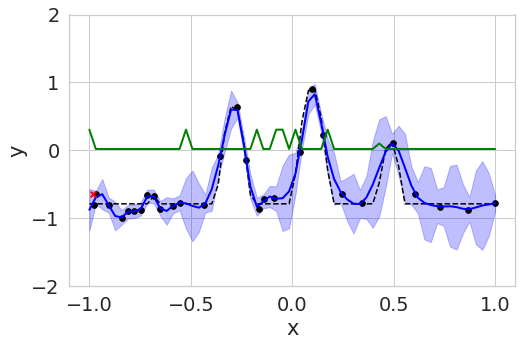

In [13]:
conformal_pts = [
    run_datashift_opt([train_split, val_split, test_split], acqf="conformal_ei") for _ in range(2)
]

11 train, 1 val, 3 test
16 train, 3 val, 4 test
22 train, 5 val, 4 test
28 train, 6 val, 5 test


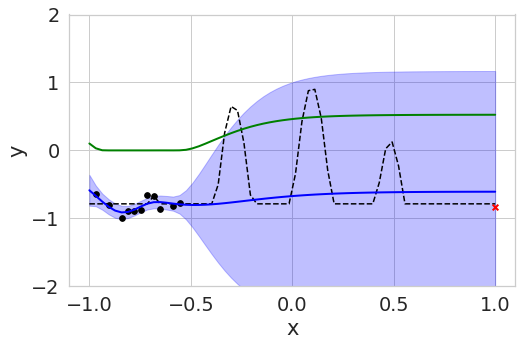

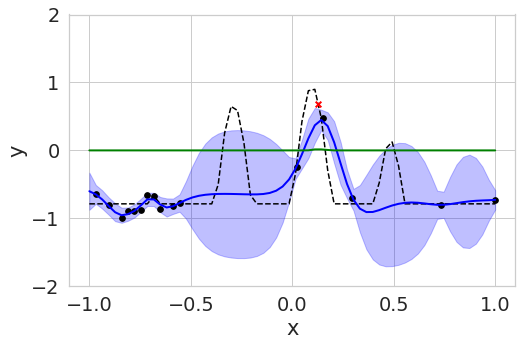

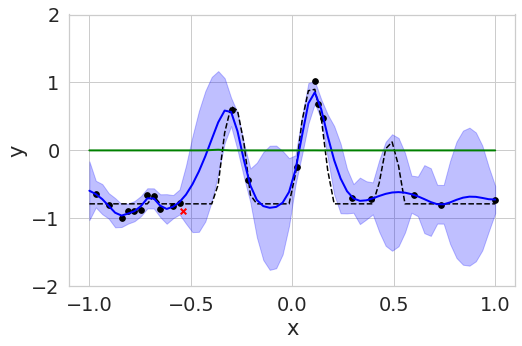

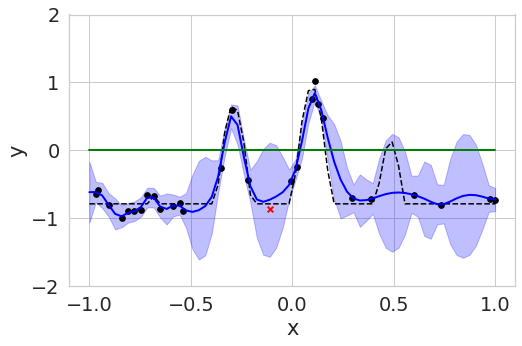

11 train, 1 val, 3 test
15 train, 4 val, 4 test
21 train, 5 val, 5 test
27 train, 5 val, 7 test


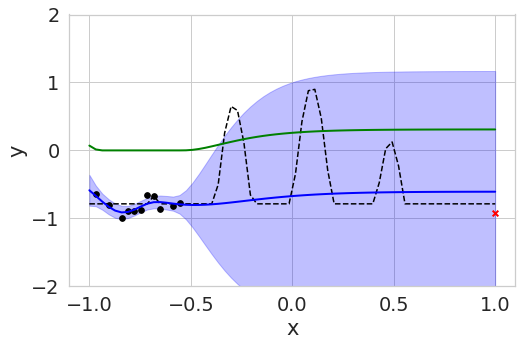

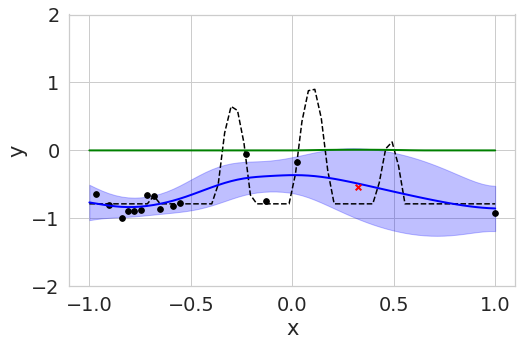

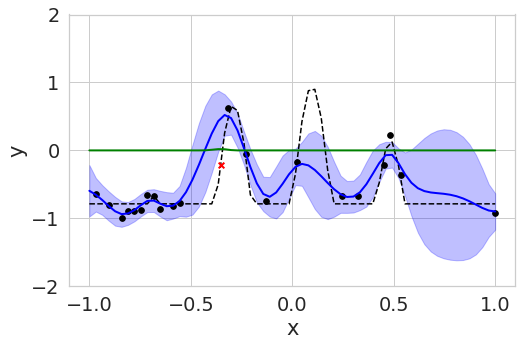

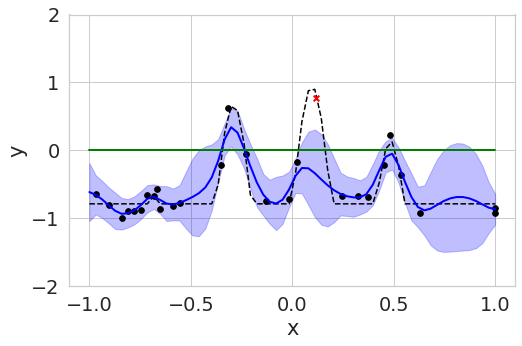

In [14]:
std_pts = [run_datashift_opt([train_split, val_split, test_split], acqf="ei") for _ in range(2)]

In [15]:
conformal = torch.stack(conformal_pts).cummax(1)[0]
std = torch.stack(std_pts).cummax(1)[0]

Text(0, 0.5, 'Best Achieved')

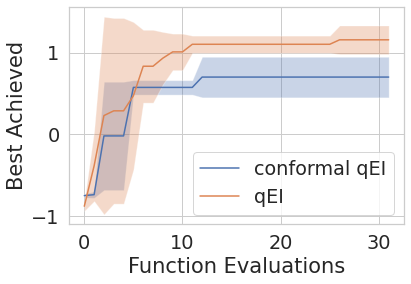

In [16]:
plt.plot(conformal.mean(0), label = "conformal qEI")
plt.fill_between(torch.arange(32), 
                 conformal.mean(0) - 2. / 5**0.5 * conformal.std(0), 
                 conformal.mean(0) + 2. / 5**0.5 * conformal.std(0), 
                 alpha = 0.3)
plt.plot(std.mean(0), label = "qEI")
plt.fill_between(torch.arange(32), 
                 std.mean(0) - 2. / 5**0.5 * std.std(0), 
                 std.mean(0) + 2. / 5**0.5 * std.std(0), 
                 alpha = 0.3)
plt.legend()
plt.xlabel("Function Evaluations")
plt.ylabel("Best Achieved")